# Exploring DeSilva Electrical Conductivity Data

**Jack Haas**

![Plasma Image](image.png)

Source: [DeSilva and Kastsouros, *Electrical conductivity of dense copper and aluminum plasmas*](https://github.com/MurilloGroupMSU/Dense-Plasma-Properties-Database/blob/master/database/DeSilvaKatsouros/DeSilvaKatsouros98.pdf)

This notebook contains the work performed to explore the DeSilva dataset. It was conducted for the Honors Option for MSU's CMSE 492 instructed by Dr. Murillo. The data and recreated visuals are sourced from [this repository](https://github.com/MurilloGroupMSU/Dense-Plasma-Properties-Database).

## Imports

In [65]:
### data manipulation ###
import numpy as np
import pandas as pd

### plotting ###
import hiplot as hip
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

### machine learning ###
# data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, LocallyLinearEmbedding, TSNE
from sklearn.model_selection import train_test_split

# hyperparameter tuning
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

# classification
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# regression



# model analysis
from sklearn.metrics import classification_report
from yellowbrick.classifier import ClassPredictionError

import warnings
warnings.filterwarnings("ignore")

## Exploratory Data Analysis

### Feature Description and Exploration:

| Feature     | Description | Units |
| ----------- | ----------- | ----------- |
| T(K)      | Temperature   | K |
| log10(rho)  | Density       | g/cc |
| log10(con)    | Conductivity  | S/m |
| Znuc     | Atomic #       | None |

The feature $\text{Z}$ was ignored for the purpose of this project.

In [2]:
combined_df = pd.read_csv('combined_cond.csv') # read combined data
combined_df.head()

,T(K),log10(rho),log10(con),Z,Znuc
0,6000,0.093828,5.66955,1.723060,13
1,10000,-0.130498,5.09673,1.384340,13
2,10000,-0.302135,4.66938,1.163650,13
3,8000,-0.565000,4.02305,0.881093,13
4,6000,-0.764547,3.35545,0.703443,13


In [3]:
combined_df.describe()

,T(K),log10(rho),log10(con),Z,Znuc
count,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000
mean,14498.472816,-0.548563,4.531197,1.709120,34.905925
std,7557.814904,0.953941,0.766991,0.850058,21.603132
min,4000.000000,-2.634510,2.466870,0.586096,13.000000
25%,10000.000000,-1.322030,3.978870,1.130270,26.000000
50%,14000.000000,-0.447697,4.289210,1.426290,28.000000
75%,18000.000000,0.242104,5.175070,2.002520,29.000000
max,42000.000000,1.116750,6.309500,4.733120,74.000000


In [4]:
combined_df['Znuc'].value_counts()

29    420
74    360
13    349
28    288
26    220
Name: Znuc, dtype: int64

### Recreating Previous Visualization

[Original source](https://github.com/MurilloGroupMSU/Dense-Plasma-Properties-Database/blob/master/database/DeSilvaKatsouros/View_DeSilva_data.ipynb)

#### Hiplot Parallel Coordinates Plot


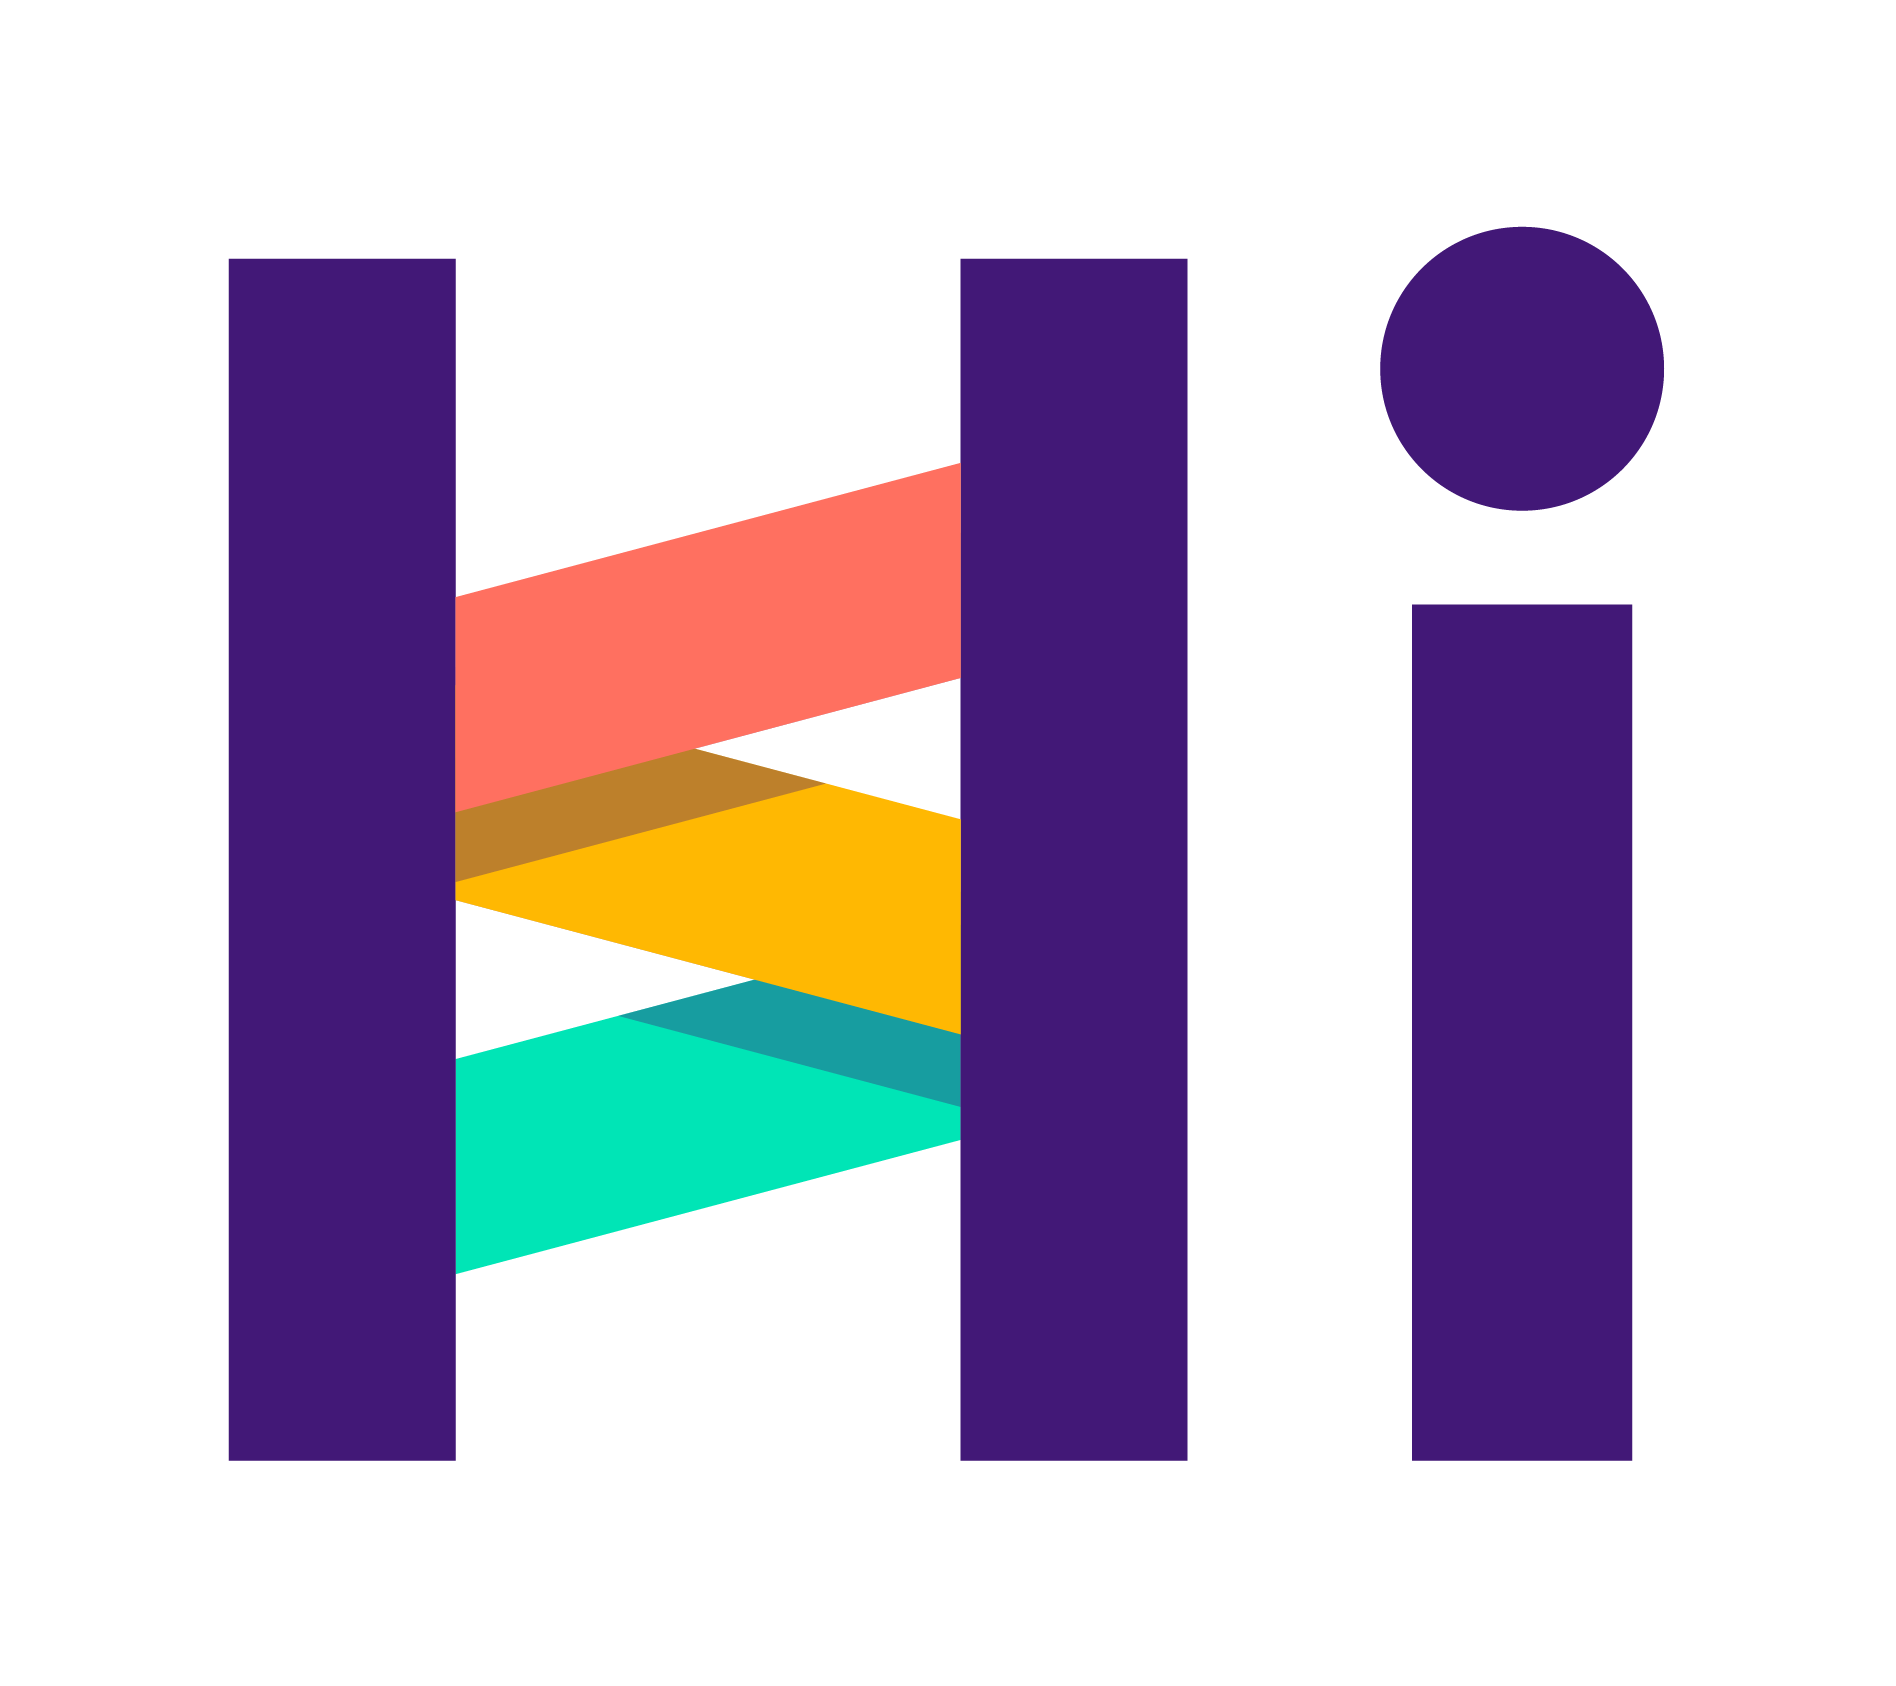

<IPython.core.display.Javascript object>

In [5]:
hip.Experiment.from_csv('combined_cond.csv').display() # recommended to use Znuc for coloring

#### Visualizing Each Element

In [6]:
to_name = {13:'Al', 26:'Ni', 28:'Fe', 29:'Cu', 74:'W'} # dictionary of atomic number to element name

combined_df['Element'] = combined_df['Znuc'].map(to_name) # add element column to df

def viz_element(element):
    plt.figure(figsize=(10,6))
    one_element = combined_df[combined_df['Znuc']==element]
    plt.scatter(one_element['T(K)'], one_element['log10(con)'], c=one_element['log10(rho)'], 
                cmap='viridis', label = element)
    plt.xlabel('T [K]')
    plt.ylabel('$\log_{10}(\sigma)$')
    plt.grid(alpha = 0.3)
    plt.text(22000, 3.3, f'Atomic #: {element}', fontsize=40, backgroundcolor = 'w', size=18)
    plt.title(to_name[element], size=18)
    plt.colorbar(label='log$_{10}$(ρ)')

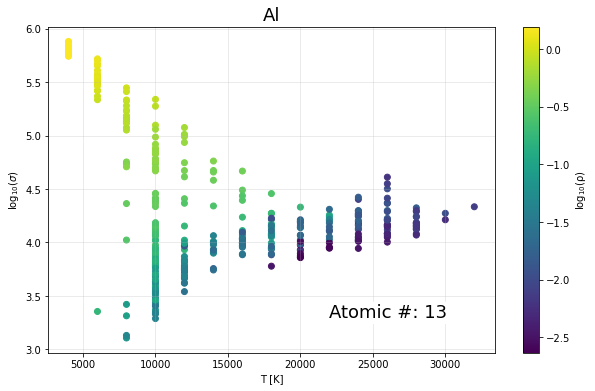

In [7]:
viz_element(13) # Al

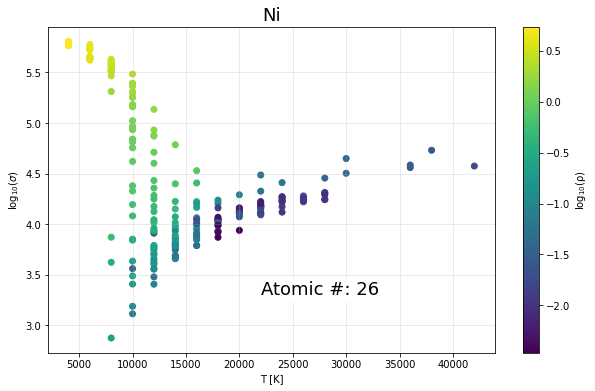

In [8]:
viz_element(26) # Ni

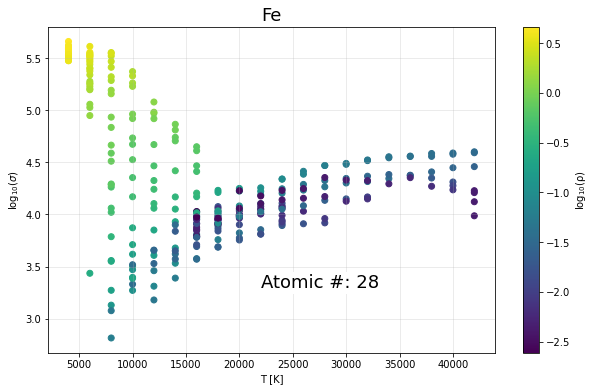

In [9]:
viz_element(28) # Fe

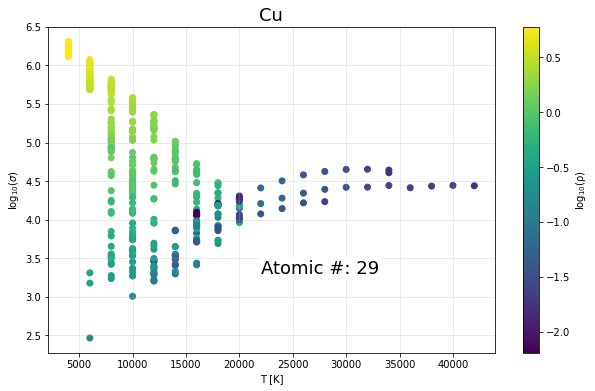

In [10]:
viz_element(29) # Cu

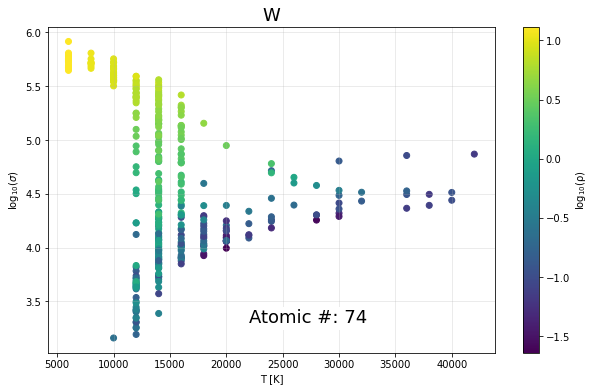

In [11]:
viz_element(74) # W

### Additional Data Exploration

#### Pairplot

<Figure size 1080x1080 with 0 Axes>

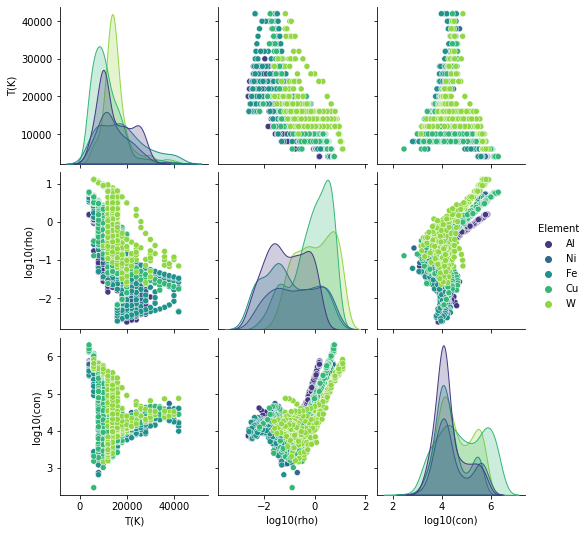

In [12]:
plt.figure(figsize=(15,15))
sns.pairplot(combined_df[['T(K)', 'log10(rho)','log10(con)', 'Element']], hue='Element', palette='viridis')
plt.show()

#### 3D Scatterplot

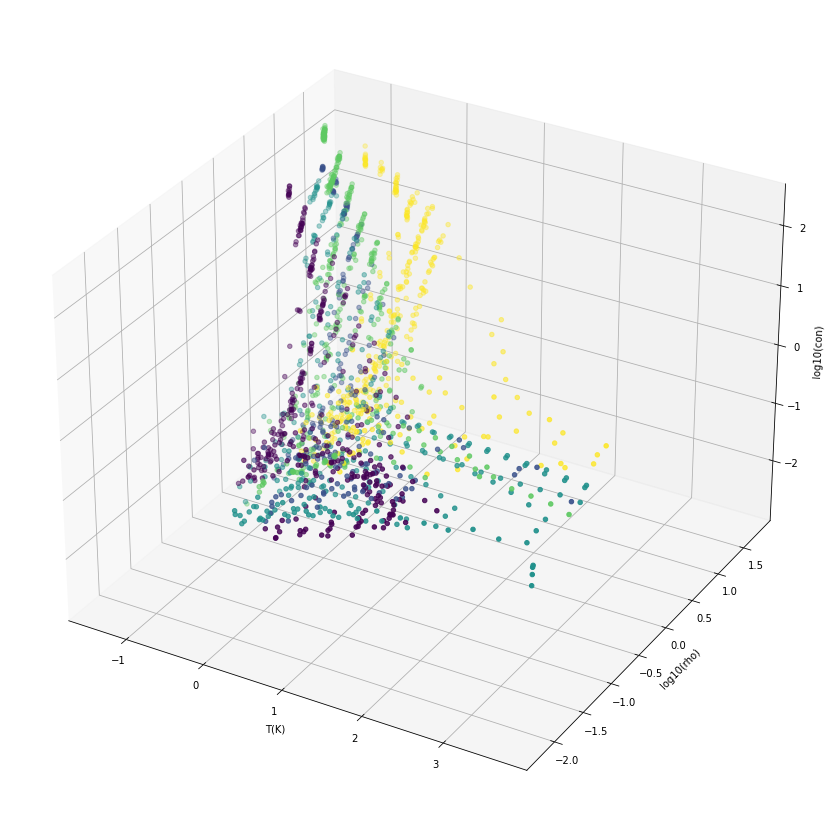

In [13]:
# scaling data
f = combined_df[['T(K)', 'log10(rho)','log10(con)']]
scaled_f = StandardScaler().fit_transform(f)

# convert for the purpose of visualization
z_to_num = {13:0, 26:1, 28:2, 29:3, 74:4}
l = combined_df['Znuc'].map(z_to_num)

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection='3d')
ax.scatter(scaled_f[:,0], scaled_f[:,1], scaled_f[:,2], c=l, cmap='viridis')
ax.set_xlabel('T(K)')
ax.set_ylabel('log10(rho)')
ax.set_zlabel('log10(con)')
plt.show()

#### PCA Scatterplot

In [77]:
def make_legend():
    custom_lines = [Line2D([0], [0], color=mpl.cm.viridis(0.), lw=4),
                    Line2D([0], [0], color=mpl.cm.viridis(0.25), lw=4),
                    Line2D([0], [0], color=mpl.cm.viridis(0.5), lw=4),
                    Line2D([0], [0], color=mpl.cm.viridis(0.75), lw=4),
                    Line2D([0], [0], color=mpl.cm.viridis(1.), lw=4)]
    plt.gca().legend(custom_lines, [13, 26, 28, 29, 74], loc='best')

Explained Variance:	 0.9417180384916959


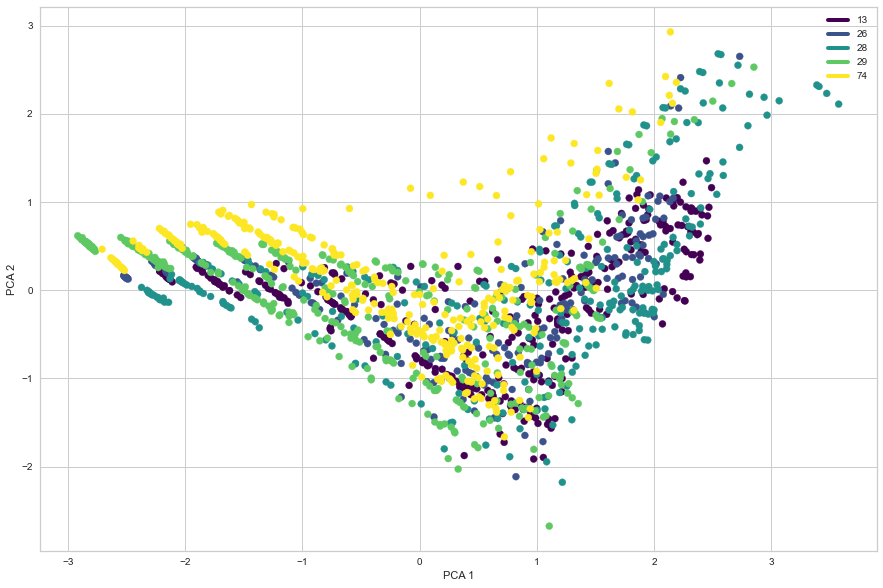

In [78]:
pca = PCA(n_components = 2).fit(scaled_f)
f_pca = pca.transform(scaled_f)
print('Explained Variance:\t', sum(pca.explained_variance_ratio_))

plt.figure(figsize=(15,10))
plt.scatter(f_pca[:,0], f_pca[:,1], c=l, cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
make_legend()
plt.show()

#### LLE Scatterplot

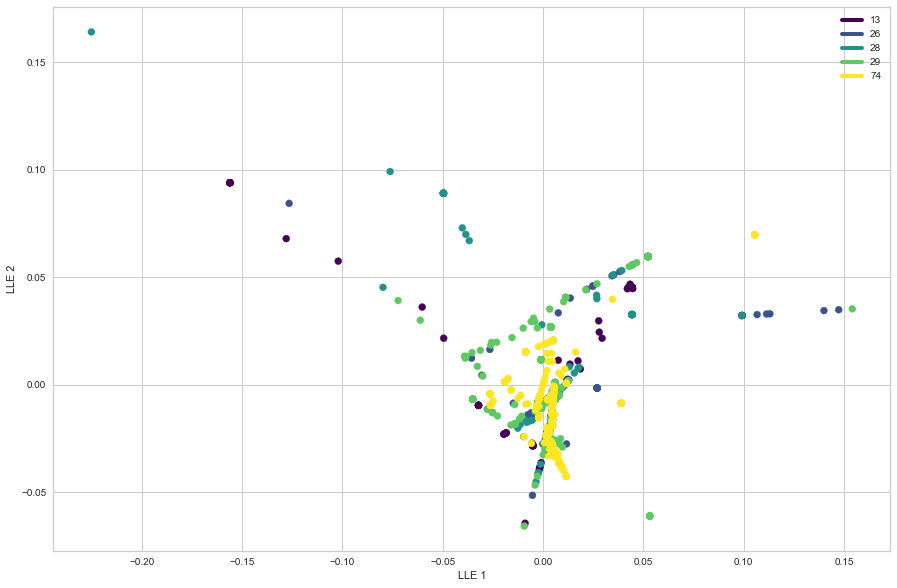

In [79]:
f_lle = LocallyLinearEmbedding(n_components=2, n_jobs=-1, eigen_solver='dense').fit_transform(scaled_f)

plt.figure(figsize=(15,10))
plt.scatter(f_lle[:,0], f_lle[:,1], c=l, cmap='viridis')
plt.xlabel('LLE 1')
plt.ylabel('LLE 2')
make_legend()
plt.show()

#### MDS Scatterplot

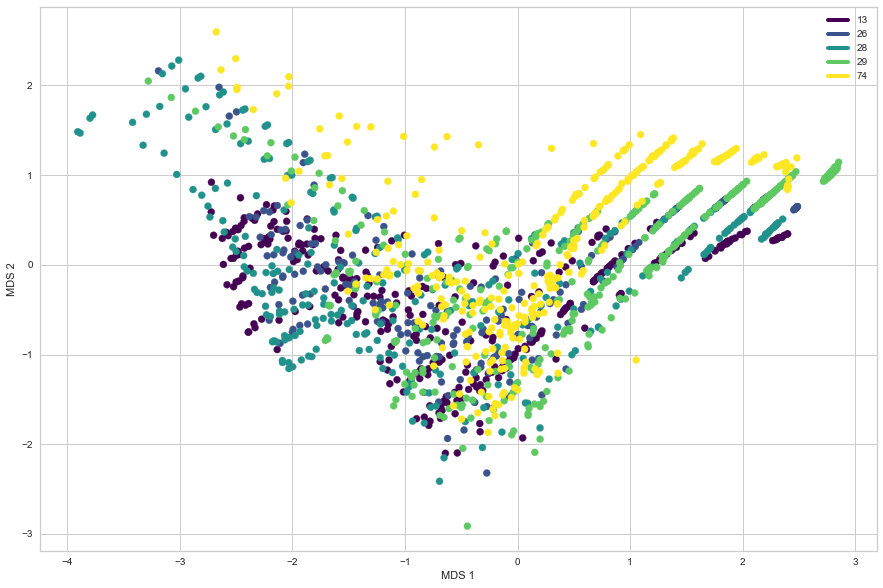

In [80]:
f_mds = MDS(n_components=2, n_jobs=-1).fit_transform(scaled_f)

plt.figure(figsize=(15,10))
plt.scatter(f_mds[:,0], f_mds[:,1], c=l, cmap='viridis')
plt.xlabel('MDS 1')
plt.ylabel('MDS 2')
make_legend()
plt.show()

#### t-SNE Scatterplot

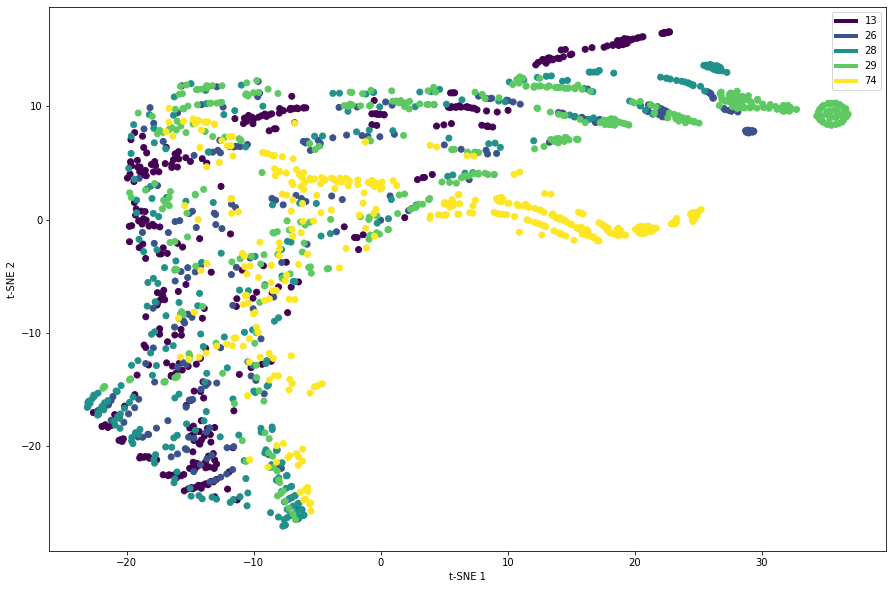

In [20]:
f_tsne = TSNE(n_components=2, perplexity=80, learning_rate='auto', init='random', 
              n_jobs=-1).fit_transform(scaled_f)

plt.figure(figsize=(15,10))
plt.scatter(f_tsne[:,0], f_tsne[:,1], c=l, cmap='viridis')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
make_legend()
plt.show()

## Element Classification from Experiment Features

### Preperation

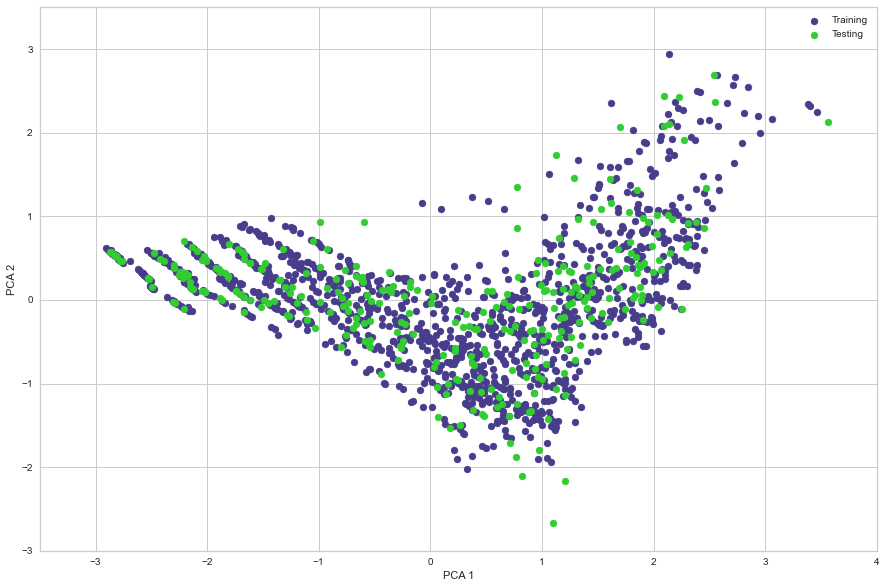

In [119]:
# split data
X_train, X_test, y_train, y_test = train_test_split(combined_df[['T(K)', 'log10(rho)','log10(con)']], 
                                                    combined_df['Znuc'], 
                                                    test_size=0.2, random_state=42)
# scale features
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# make labels for visualization
l_train = y_train.map(z_to_num)
l_test = y_test.map(z_to_num)

pca = PCA(n_components = 2).fit(X_train_s)
tr = pca.transform(X_train_s)
te = pca.transform(X_test_s)

plt.figure(figsize=(15,10))
plt.scatter(tr[:,0], tr[:,1], c='darkslateblue', label='Training')
plt.scatter(te[:,0], te[:,1], c='limegreen', label='Testing')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.xlim(-3.5, 4)
plt.ylim(-3, 3.5)
plt.legend()
plt.show()

In [154]:
print(f'Visualization PCA Explained Variance: {sum(pca.explained_variance_ratio_)}')

Visualization PCA Explained Variance: 0.94098139726205


In [127]:
def plot_decision_boundary(clf, viz_tfmr):   
    "Function for plotting decisions boundaries when all five elements are being predicted"
    
    # get decision boundary of classifier 
    step = 0.05
    xx, yy = np.meshgrid(np.arange(-3.5, 4 + step, step), np.arange(-3, 3.5 + step, step))
    Z = clf.predict(viz_tfmr.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = np.vectorize(z_to_num.get)(Z)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(20,16))
    
    # plot training data on boundary
    plt.subplot(2, 2, 1)
    plt.title('Training Data')
    plt.gca().contourf(xx, yy, Z, cmap=plt.cm.viridis, alpha=0.4)
    plt.scatter(tr[:,0], tr[:,1], c=l_train, cmap='viridis')
    plt.xlim(-3.5, 4)
    plt.ylim(-3, 3.5)
    plt.text(-3.1, -2.7, f'Training Accuracy: {clf.score(X_train_s, y_train)}', backgroundcolor='w')
    make_legend()

    # plot testing data on boundary
    plt.subplot(2, 2, 2)
    plt.title('Testing Data')
    plt.gca().contourf(xx, yy, Z, cmap=plt.cm.viridis, alpha=0.4)
    plt.scatter(te[:,0], te[:,1], c=l_test, cmap='viridis')
    plt.xlim(-3.5, 4)
    plt.ylim(-3, 3.5)
    plt.text(-3.1, -2.7, f'Testing Accuracy: {clf.score(X_test_s, y_test)}', backgroundcolor='w')
    make_legend()
    
    # plot training class prediction error
    plt.subplot(2, 2, 3)
    plt.title('Training Class Prediction Error')
    visualizer1 = ClassPredictionError(clf)
    visualizer1.score(X_train_s, y_train)
    visualizer1.draw()
    
    # plot testing class prediction error
    plt.subplot(2, 2, 4)
    plt.title('Testing Class Prediction Error')
    visualizer2 = ClassPredictionError(clf)
    visualizer2.score(X_test_s, y_test)
    visualizer2.draw()

### SVM

In [83]:
param_grid = {'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'degree': [2, 3, 4, 5],
              'gamma': ['scale', 'auto'],
              'shrinking': [True, False]}

base_estimator = SVC(class_weight='balanced', random_state=42)

sh = HalvingGridSearchCV(base_estimator, param_grid, cv=5, factor=2, min_resources='exhaust',
                         n_jobs=-1).fit(X_train_s, y_train)

In [84]:
print(sh.best_score_)
print(sh.best_params_)
best_svm = sh.best_estimator_

0.7634276729559748
{'C': 10000.0, 'degree': 5, 'gamma': 'auto', 'kernel': 'rbf', 'shrinking': True}


In [35]:
best_svm = SVC(class_weight='balanced', random_state=42, C=10000.0, gamma='auto', kernel='rbf', 
               shrinking=True).fit(X_train_s, y_train)

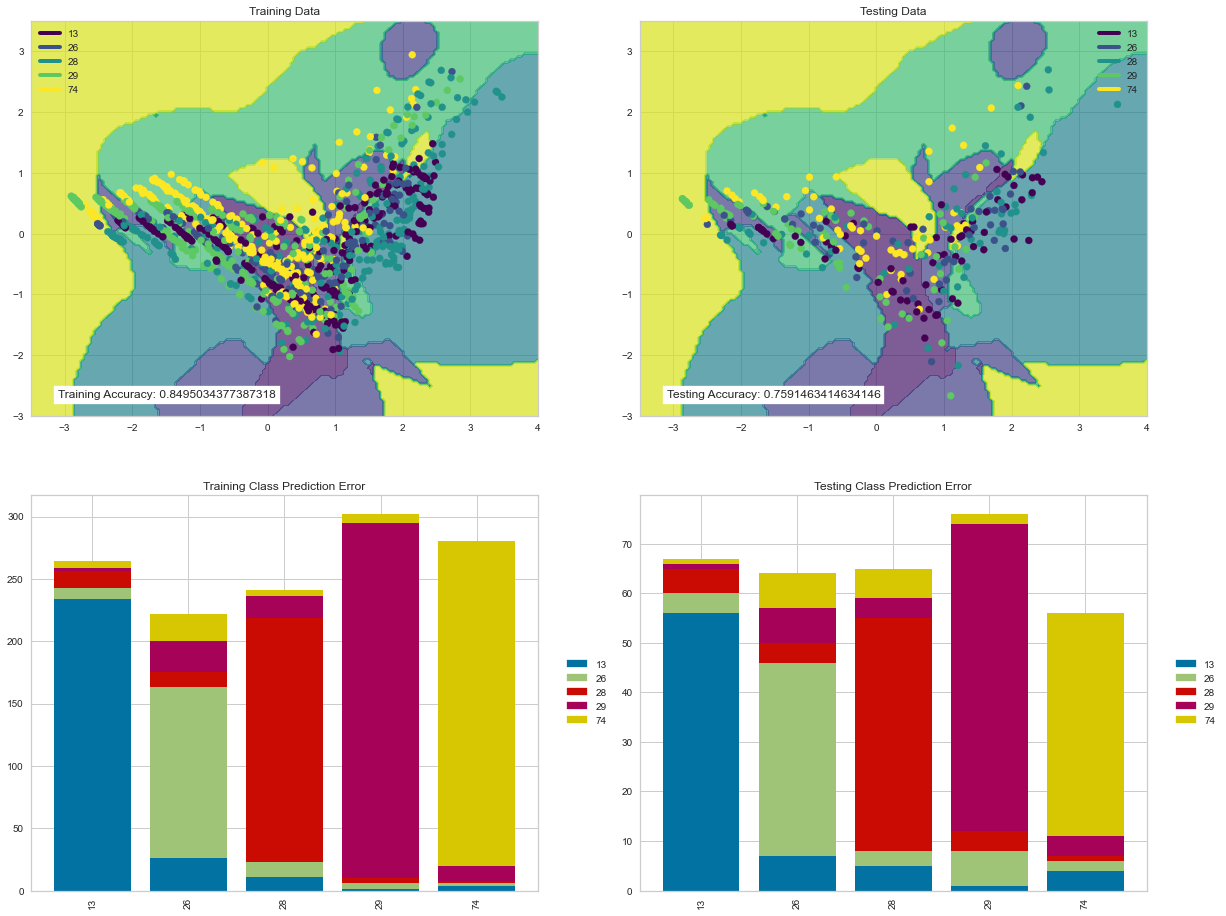

In [92]:
plot_decision_boundary(best_svm, pca)

### Random Forest

In [85]:
param_grid = { 
    'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500],
    'criterion' :['gini', 'entropy'],
    'max_depth' : [2, 4, 6, 8, 10, 12, 16, 18, 20],
}

base_estimator = RandomForestClassifier(class_weight='balanced', random_state=42, max_features='auto')

sh = HalvingGridSearchCV(base_estimator, param_grid, cv=5, factor=2, min_resources='exhaust',
                         n_jobs=-1).fit(X_train_s, y_train)

In [86]:
print(sh.best_score_)
print(sh.best_params_)
best_rf = sh.best_estimator_

0.7046147798742137
{'criterion': 'gini', 'max_depth': 12, 'n_estimators': 450}


In [89]:
best_rf = RandomForestClassifier(class_weight='balanced', random_state=42, max_features='auto',
                                 n_estimators=450, criterion='gini', max_depth=12).fit(X_train_s, y_train)

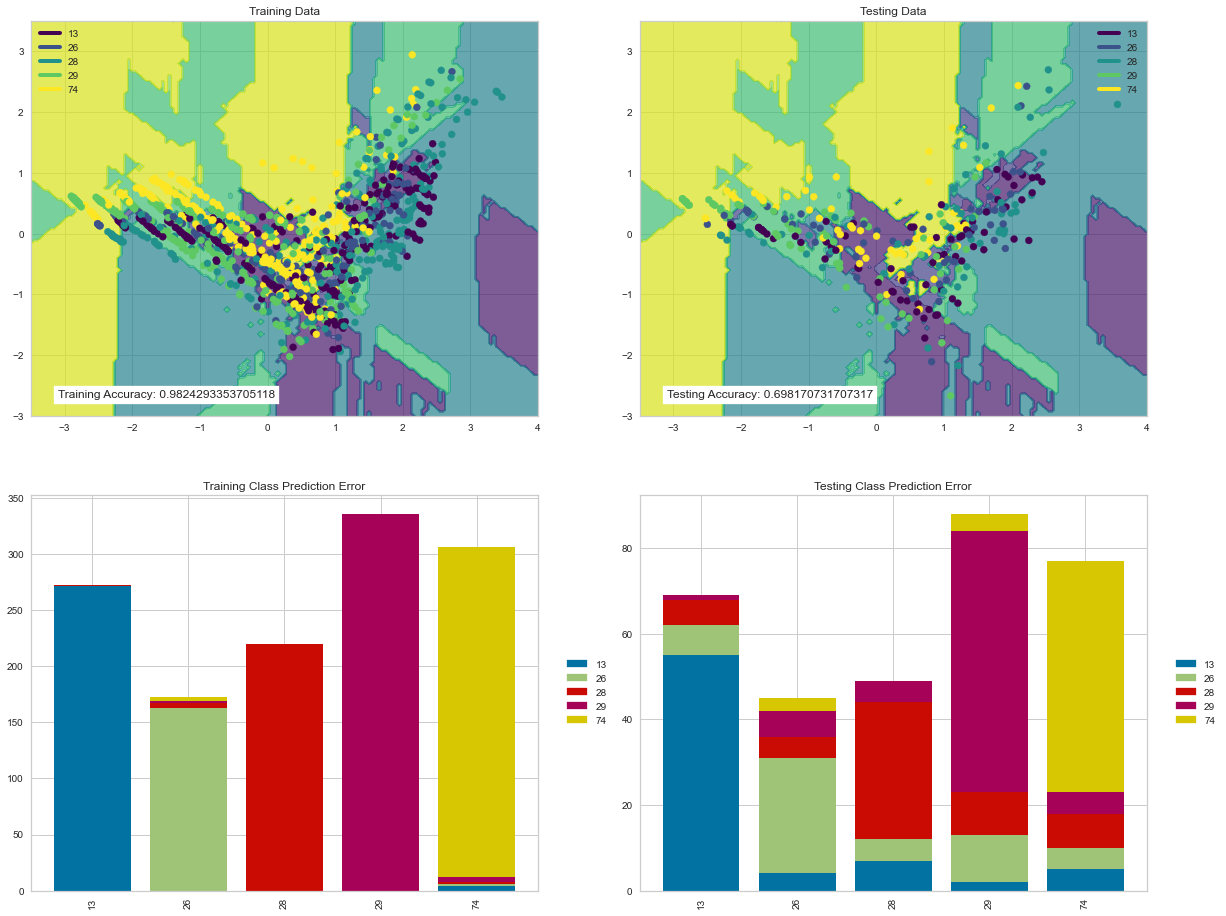

In [93]:
plot_decision_boundary(best_rf, pca)

### Bonus: Classification of only Al and W

Not much confusion between 13 (Al) and 74 (W).

In [116]:
binary = combined_df[combined_df['Znuc'].isin([13, 74])]
binary['Znuc'].value_counts()

74    360
13    349
Name: Znuc, dtype: int64

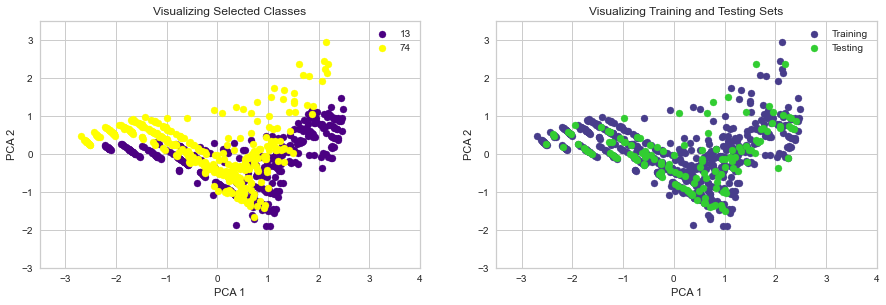

In [126]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(binary[['T(K)', 'log10(rho)','log10(con)']], 
                                                            binary['Znuc'], 
                                                            test_size=0.2, random_state=42)

trfmd = pca.transform(scaler.transform(binary[['T(K)', 'log10(rho)','log10(con)']]))
al = trfmd[binary['Znuc'] == 13, :]
w = trfmd[binary['Znuc'] == 74, :]

X_train_b_s = scaler.transform(X_train_b)
X_test_b_s = scaler.transform(X_test_b)

tr = pca.transform(X_train_b_s)
te = pca.transform(X_test_b_s)

plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.title('Visualizing Selected Classes')
plt.scatter(al[:,0], al[:,1], c='indigo', label='13')
plt.scatter(w[:,0], w[:,1], c='yellow', label='74')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.xlim(-3.5, 4)
plt.ylim(-3, 3.5)
plt.legend()

plt.subplot(2, 2, 2)
plt.title('Visualizing Training and Testing Sets')
plt.scatter(tr[:,0], tr[:,1], c='darkslateblue', label='Training')
plt.scatter(te[:,0], te[:,1], c='limegreen', label='Testing')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.xlim(-3.5, 4)
plt.ylim(-3, 3.5)
plt.legend()
plt.show()

In [140]:
param_grid = {'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5],
              'gamma': ['scale', 'auto'],
              'shrinking': [True, False]}

base_estimator = SVC(class_weight='balanced', random_state=42, kernel='rbf')

sh = HalvingGridSearchCV(base_estimator, param_grid, cv=5, factor=2, min_resources='exhaust',
                         n_jobs=-1).fit(X_train_b_s, y_train_b)

In [141]:
print(sh.best_score_)
print(sh.best_params_)
best_b_svm = sh.best_estimator_

0.943204365079365
{'C': 100.0, 'gamma': 'scale', 'shrinking': False}


In [142]:
best_b_svm = SVC(class_weight='balanced', random_state=42, kernel='rbf', C=10000.0, gamma='auto',
                 shrinking=False).fit(X_train_b_s, y_train_b)

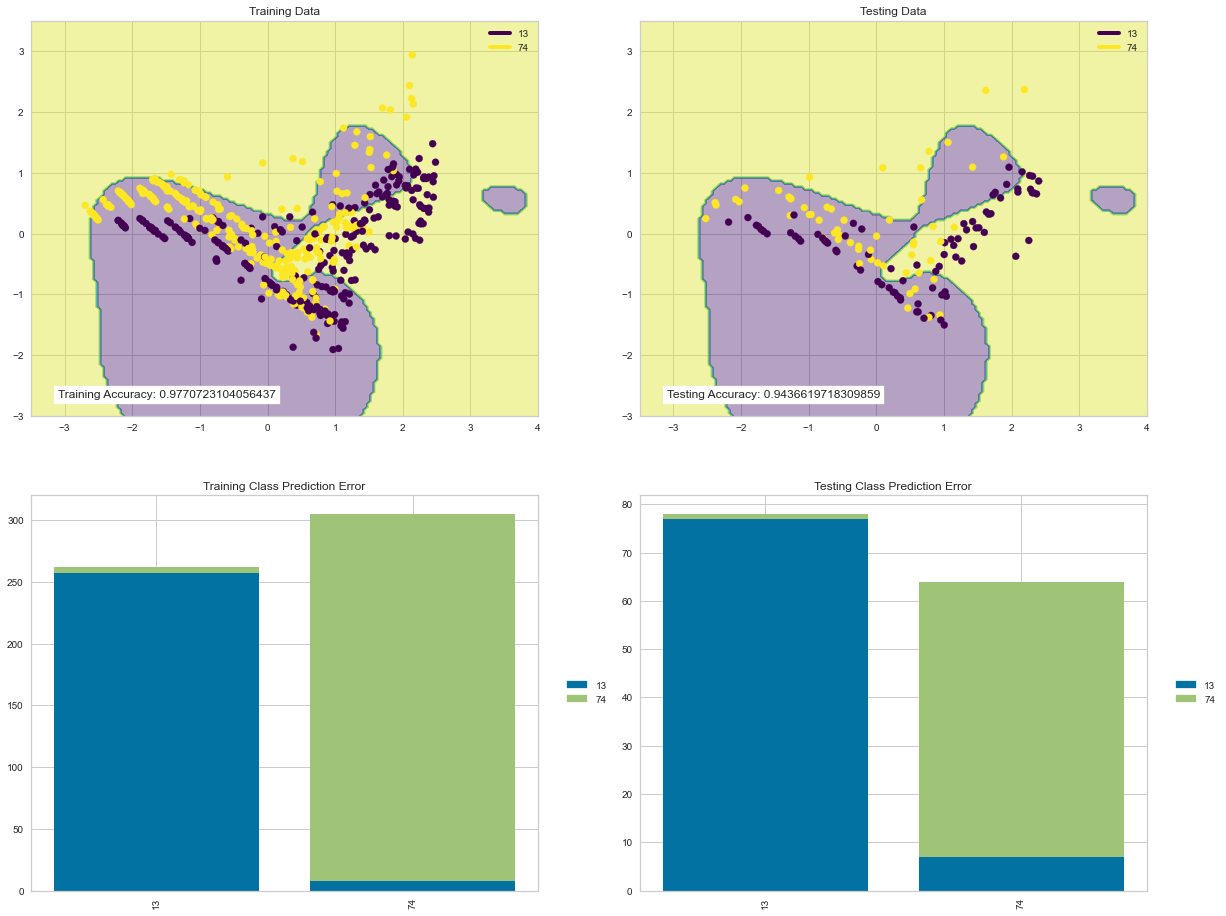

In [152]:
# plotting binary results

# get decision boundary of classifier 
step = 0.05
xx, yy = np.meshgrid(np.arange(-3.5, 4 + step, step), np.arange(-3, 3.5 + step, step))
Z = best_b_svm.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
Z = np.vectorize(z_to_num.get)(Z)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(20,16))
    
# plot training data on boundary
plt.subplot(2, 2, 1)
plt.title('Training Data')
plt.gca().contourf(xx, yy, Z, cmap=plt.cm.viridis, alpha=0.4)
plt.scatter(tr[:,0], tr[:,1], c=y_train_b, cmap='viridis')
plt.xlim(-3.5, 4)
plt.ylim(-3, 3.5)
plt.text(-3.1, -2.7, f'Training Accuracy: {best_b_svm.score(X_train_b_s, y_train_b)}', backgroundcolor='w')
custom_lines = [Line2D([0], [0], color=mpl.cm.viridis(0.), lw=4),
                Line2D([0], [0], color=mpl.cm.viridis(1.), lw=4)]
plt.gca().legend(custom_lines, [13, 74], loc='best')

# plot testing data on boundary
plt.subplot(2, 2, 2)
plt.title('Testing Data')
plt.gca().contourf(xx, yy, Z, cmap=plt.cm.viridis, alpha=0.4)
plt.scatter(te[:,0], te[:,1], c=y_test_b, cmap='viridis')
plt.xlim(-3.5, 4)
plt.ylim(-3, 3.5)
plt.text(-3.1, -2.7, f'Testing Accuracy: {best_b_svm.score(X_test_b_s, y_test_b)}', backgroundcolor='w')
custom_lines = [Line2D([0], [0], color=mpl.cm.viridis(0.), lw=4),
                Line2D([0], [0], color=mpl.cm.viridis(1.), lw=4)]
plt.gca().legend(custom_lines, [13, 74], loc='best')

# plot training class prediction error
plt.subplot(2, 2, 3)
plt.title('Training Class Prediction Error')
visualizer1 = ClassPredictionError(best_b_svm)
visualizer1.score(X_train_b_s, y_train_b)
visualizer1.draw()
    
# plot testing class prediction error
plt.subplot(2, 2, 4)
plt.title('Testing Class Prediction Error')
visualizer2 = ClassPredictionError(best_b_svm)
visualizer2.score(X_test_b_s, y_test_b)
visualizer2.draw()

plt.show()

## Predicting Conductivity

---